In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List
from IPython.display import display

# Constants

ALL_STARS_DATASET_LOCATION = './datasets/allstar_player_talent.csv'

In [2]:
def get_head_and_tail(dataframe: pd.DataFrame, head: int, tail: int) -> pd.DataFrame:
    """
    Devuelve un pandas DataFrame con las primer X filas (@param head) y las ultimas Y filas (@param tail).

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param head: Int con cantidad de filas a utilizar contando desde el principio del dataframe.
    @param tail: Int con cantidad de filas a utilizar contando desde el final del dataframe

    @return: Pandas DataFrame.
    """
    
    return pd.concat([dataframe.head(n=head), dataframe.tail(n=tail)])

In [3]:
def get_na_from_df(dataframe: pd.DataFrame) -> pd.Series:
    """
    Devuelve un pandas Series con la cantidad de filas vacias por cada fila.

    @param dataframe: Pandas DataFrame con los datos a utilizar.

    @return: Pandas Series.
    """
    
    return dataframe.isna().sum()

In [4]:
# Valor default utilizado para nombar el total de columna por groupby.
DEFAULT_COUNT_COLUMN_NAME = 'count'

def get_distinct_values_for_column(dataframe: pd.DataFrame, column: str, 
    count_name=DEFAULT_COUNT_COLUMN_NAME) -> pd.DataFrame:
    
    """
    Devuelve un dataframe agrupado por una columna y con el total de filas para cada uno de los 
    valores de esa columna.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param column: Str con el nombre de la columna por la que desea agrupar.
    @param count_name: Str con el nombre de la columna con el total de filas. El valor
    defualt es DEFAULT_COUNT_COLUMN_NAME.

    @return: Pandas DataFrame
    """

    return dataframe.groupby(by=column).size().reset_index(name='count')

def get_all_group_by_for_each_column(dataframe: pd.DataFrame, columns: List[str], 
    count_name=DEFAULT_COUNT_COLUMN_NAME) -> List[pd.DataFrame]:

    """
    Devuelve una lista de  dataframes agrupados por una columna y con el total de filas para cada uno de los 
    valores de esa columna.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param column: List[Str] con el nombre de cada una de las
    columnas por las que desea agrupar.
    @param count_name: Str con el nombre de la columna con el total de filas. El valor
    defualt es DEFAULT_COUNT_COLUMN_NAME.

    @return: List of Pandas DataFrame
    """

    list_of_dataframes = []
    for column in columns:
        list_of_dataframes.append(get_distinct_values_for_column(
            dataframe=dataframe, column=column, count_name=count_name))
    
    return list_of_dataframes

def draw_bar_chart(dataframe: pd.DataFrame, x_column: str, y_column: str) -> None:
    """
    Devuelve un gráfico de barras usando el Pandas DataFrame pasado.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param x_column: Str con el nombre de la columna a usar en el eje x.
    @param y_column: Str con el nombre de la columna a user en el eje y.

    @return: None
    """
    
    plt.bar(x_column, y_column, data=dataframe)
    plt.xlabel(x_column),
    plt.xticks(rotation = 90)
    plt.ylabel(y_column)
    plt.title('Cantidad de filas por {}'.format(x_column))
    plt.show()

In [5]:
VALID_SUMMARIZATION_OPERATIONS = ['mean', 'median', 'mode','min','max']
COLUMNS_COLUMN_NAME_DEFAULT = 'Nombre de columna'

def get_summarization_from_data(
    dataframe: pd.DataFrame, columns: List[str], summarization_op: str,
    valid_operations: List[str] = VALID_SUMMARIZATION_OPERATIONS) -> dict:
    """
    Obtiene la sumarización especificada para las columnas pasadas.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param columns: List str de las columnas a sumarizar.
    @param summarization_op: Str con la operación a realizar
    @param valid_operations: List str con las operaciones validas.

    @return: Diccionario con el resultado de la operación
    utilizando como key el nombre de la columna y como value el resultado.
    """

    if summarization_op not in valid_operations:
        raise ValueError('Invalid operation {}. Valid operations are {}'.format(
            summarization_op, valid_operations))

    return getattr(dataframe[columns], summarization_op)().to_dict()


def create_dataframe_with_each_summarization(
    dataframe: pd.DataFrame, columns: List[str], summarization_ops: List[str], 
    columns_column_name: str = COLUMNS_COLUMN_NAME_DEFAULT) -> pd.DataFrame:
    """
    Obtiene las sumarizaciones especificada para las columnas pasadas.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param columns: List str de las columnas a sumarizar.
    @param summarization_ops: Str con las operaciones a realizar
    @param columns_column_name: Str con el nombre a asignarle a la
    columna con los nombres descriptivos de cada columna procesada.

    @return: Pandas DataFrame con los datos de cada sumarizacion por
    columnas.
    """

    initial_column_name = columns_column_name
    new_df = pd.DataFrame(columns, columns=[initial_column_name])

    for operation in summarization_ops:
        new_df[operation] = new_df[initial_column_name].map(
            get_summarization_from_data(
                dataframe=dataframe, 
                columns=columns, 
                summarization_op=operation
            )
        )
    
    return  new_df

def quantile_value_is_valid(value: float) -> bool:
    """
    Valida que el float pasado sea un valor valido de cuantil.

    @param value: float con el número a validar.

    @return: True si el value es valido, sino False.
    """

    if value > 0 and value < 1:
        return True
    return False

def get_quantile_for_data(dataframe: pd.DataFrame, columns: List[str], quantile: float) -> dict:
    """
    Calcula el cuantil especificado para las columnas pasadas.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param columns: List str de las columnas a utilizar para calcular los cuantiles.   
    @param quantile: float con el valor del cuantil a calcular.

    @return: Diccionario que usa como key el nombre de la columna y como
    value el resultado del calculo del cuantil. 
    """
    
    if not quantile_value_is_valid(value=quantile):
        raise ValueError('Quantile value must be between 0 and 1, passed value: {}'.format(quantile))

    return dataframe[columns].quantile(q=quantile).to_dict()

def create_dataframe_with_quantiles(
    dataframe: pd.DataFrame, columns: List[str], quantiles: List[float],
    columns_column_name: str = COLUMNS_COLUMN_NAME_DEFAULT) -> pd.DataFrame:
    """
    Obtiene los cuantiles especificados para las columnas pasadas.

    @param dataframe: Pandas DataFrame con los datos a utilizar.
    @param columns: List str de las columnas a utilizar para calcular los cuantiles.
    @param quantiles: List float con los cuantiles a calcular.
    @param columns_column_name: Str con el nombre a asignarle a la
    columna con los nombres descriptivos de cada columna procesada.

    @return: Pandas DataFrame con los datos de cada cuantil por
    columnas.
    """

    initial_column_name = columns_column_name
    new_df = pd.DataFrame(columns, columns=[initial_column_name])

    for quantile in quantiles:
        new_df['Quantile {}%'.format(quantile * 100)] = new_df[initial_column_name].map(
            get_quantile_for_data(
                dataframe=dataframe,
                columns=columns,
                quantile=quantile
            )
        )
    
    return new_df


In [6]:
all_stars_df = pd.read_csv(ALL_STARS_DATASET_LOCATION, header=0)

## Resumen del dataset
### Conceptos de Baseball
- **(PA) Plate Appearance**: A un jugador se le atribuye una apariencia de placa cada vez que completa un turno de bateo.
- **(IP) Innings pitched**: Son el número de entradas que ha completado un lanzador, medido por el número de bateadores y corredores de base que se eliminan mientras el lanzador está en el montículo de lanzamiento en un juego.
- **(ASG) All Stars Game**: Partido de All Stars.
- **Carreras ofensivas**: Es una estadística de béisbol que mide la cantidad de carreras que un jugador gano o le costó a su equipo en ofensiva en relación con un jugador promedio
- **Carreras defensivas**: Es una estadística de béisbol que mide la cantidad de carreras que un jugador salvó o le costó a su equipo en defensa en relación con un jugador promedio

### Descripción de cada columna

Columnas del dataset All Players Talent
| Columna  | Descripción  |
|---|---|
| bbref_ID  | ID del jugado basado en [Baseball-Reference.com](https://www.baseball-reference.com/). |
| yearID  | La temporada  |
| gameNum  | Orden del partido dependiendo de la temporada.  |
| gameId  | ID del partido basado en [Baseball-Reference.com](https://www.baseball-reference.com/).   |
| lgID  |  ID de la liga del equipo de All Stars. |
| startingPos  | Posición en la que juego el jugador. [Convención usada.](https://en.wikipedia.org/wiki/Baseball_positions#:~:text=Each%20position%20conventionally%20has%20an,and%209%20(right%20fielder).)  |
| OFF600  | Estimación de talento ofensivo, en carreras por encima del promedio de la liga por cada 600 *PA*. [Link para más información sobre Offensive Stats](https://www.rookieroad.com/baseball/statistics/offensive-stats/). |
| DEF600  | Estimación del talento de fildeo, en carreras por encima del promedio de la liga por cada 600 *PA*. [Link para más información sobre Deffensive Stats](https://www.rookieroad.com/baseball/statistics/defensive-stats/). |
| PITCH200  | Estimación del talento de lanzamiento, en carreras por encima del promedio de la liga por 200 *IP*. [Link para más información sobre Pitcher Stats](https://www.rookieroad.com/baseball/statistics/pitcher-stats/). |
| asg_PA  | Número de PA en el partido.  |
| asg_IP  | Número de IP en el partido.  |
| OFFper9innASG | Carreras ofensivas esperadas añadidas por encima del promedio (de talento) basadas en PA en ASG, escaladas a un juego de 9 entradas  |
| DEFper9innASG | Carreras defensivas esperadas añadidas por encima del promedio (de talento) basadas en PA en ASG, escaladas a un juego de 9 entradas  |
| PITper9innASG | Carreras de lanzamiento esperadas agregadas por encima del promedio (de talento) basadas en IP en ASG, escaladas a un juego de 9 entradas  |
| TOTper9innASG | Carreras esperadas añadidas por encima del promedio (de talento) basadas en PA/IP en ASG, escaladas a un juego de 9 entradas  |


In [7]:
get_head_and_tail(all_stars_df, head=10, tail=10)

,bbref_ID,yearID,gameNum,gameID,lgID,startingPos,OFF600,DEF600,PITCH200,asg_PA,asg_IP,OFFper9innASG,DEFper9innASG,PITper9innASG,TOTper9innASG
0,goldspa01,2015,0,NLS201507140,NL,3.0,36.755724,-0.117214,0.000000,3,0.0,0.183779,-0.000586,0.000000,0.183193
1,mccutan01,2015,0,NLS201507140,NL,8.0,33.676168,-0.168658,0.000000,3,0.0,0.168381,-0.000843,0.000000,0.167538
2,harpebr03,2015,0,NLS201507140,NL,9.0,30.925454,1.382969,0.000000,3,0.0,0.154627,0.006915,0.000000,0.161542
3,greinza01,2015,0,NLS201507140,NL,1.0,0.000000,0.000000,15.645611,0,2.0,0.000000,0.000000,0.156456,0.156456
4,poseybu01,2015,0,NLS201507140,NL,2.0,21.692969,7.595546,0.000000,2,0.0,0.072310,0.025318,0.000000,0.097628
5,frazito01,2015,0,NLS201507140,NL,5.0,14.534261,4.787243,0.000000,3,0.0,0.072671,0.023936,0.000000,0.096608
6,rizzoan01,2015,0,NLS201507140,NL,0.0,22.171148,0.670665,0.000000,2,0.0,0.073904,0.002236,0.000000,0.076139
7,kershcl01,2015,0,NLS201507140,NL,NaN,0.000000,0.000000,14.695875,0,1.0,0.000000,0.000000,0.073479,0.073479
8,peraljh01,2015,0,NLS201507140,NL,6.0,7.193126,10.385048,0.000000,2,0.0,0.023977,0.034617,0.000000,0.058594
9,crawfbr01,2015,0,NLS201507140,NL,NaN,2.372143,13.079626,0.000000,2,0.0,0.007907,0.043599,0.000000,0.051506


### Cantidad de nulos por columna

In [8]:
get_na_from_df(dataframe=all_stars_df)

bbref_ID            0
yearID              0
gameNum             0
gameID              0
lgID                0
startingPos      2351
OFF600              0
DEF600              0
PITCH200            0
asg_PA              0
asg_IP              0
OFFper9innASG       0
DEFper9innASG       0
PITper9innASG       0
TOTper9innASG       0
dtype: int64

## Análisis de variables cualitativas
### Columnas con variables cualitativas

- yearID
- gameNum 
- lgID
- startingPos

yearID


,yearID,count
0,1933,30
1,1934,35
2,1935,31
3,1936,31
4,1937,31
...,...,...
77,2011,60
78,2012,61
79,2013,55
80,2014,62


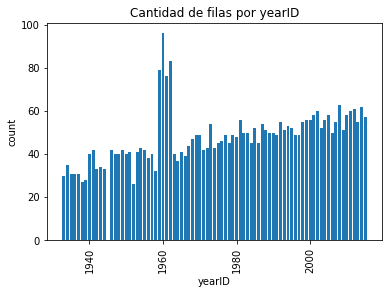

gameNum


,gameNum,count
0,0,3596
1,1,169
2,2,165


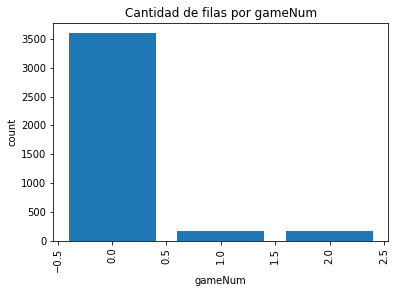

lgID


,lgID,count
0,AL,1931
1,NL,1999


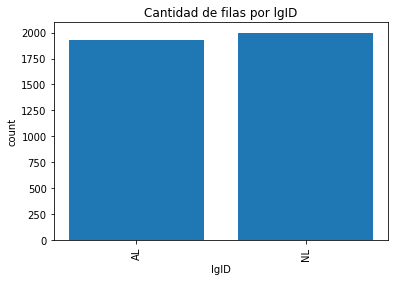

startingPos


,startingPos,count
0,0.0,10
1,1.0,172
2,2.0,172
3,3.0,172
4,4.0,172
5,5.0,172
6,6.0,171
7,7.0,172
8,8.0,172
9,9.0,172


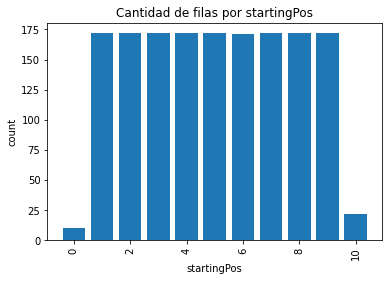

In [20]:
list_of_qualitative_columns = ['yearID', 'gameNum', 'lgID', 'startingPos']

group_by_dfs = get_all_group_by_for_each_column(dataframe=all_stars_df, columns=list_of_qualitative_columns)

for column, df in zip(list_of_qualitative_columns, group_by_dfs):
    print(column)
    display(df)
    draw_bar_chart(dataframe=df, x_column=column, y_column=DEFAULT_COUNT_COLUMN_NAME)

### ¿Es posible realizar este gráfico con un histograma?

## Análisis de variables cuantitatuvas
### Columnas con variables cuantitativas

- OFF600
- DEF600 
- PITCH200 
- asg_PA
- asg_IP
- OFFper9innASG
- DEFper9innASG
- PITper9innASG
- TOTper9innASG

In [10]:
list_of_quantitative_columns = ['OFF600', 'DEF600', 'PITCH200', 'asg_PA', 'asg_IP', 'OFFper9innASG', 'DEFper9innASG', 'PITper9innASG', 'TOTper9innASG']
summarization_operations = ['mean', 'median', 'mode','min','max']


summarized_df = create_dataframe_with_each_summarization(
    dataframe=all_stars_df,
    columns=list_of_quantitative_columns,
    summarization_ops=summarization_operations)

quantiles_df = create_dataframe_with_quantiles(
    dataframe=all_stars_df, 
    columns=list_of_quantitative_columns, 
    quantiles=[0.25, 0.75])

pd.merge(left=summarized_df, right=quantiles_df, left_on='Nombre de columna', right_on='Nombre de columna')


,Nombre de columna,mean,median,mode,min,max,Quantile 25.0%,Quantile 75.0%
0,OFF600,10.268185,7.192174,{0: 0.0},-36.614886,79.540127,0.000000,18.889090
1,DEF600,0.925774,0.000000,{0: 0.0},-22.271714,31.083132,-2.758707,4.507549
2,PITCH200,2.142385,0.000000,{0: 0.0},-9.884523,31.811326,0.000000,0.000000
3,asg_PA,1.620611,1.000000,{0: 0},0.000000,7.000000,0.000000,3.000000
4,asg_IP,0.397625,0.000000,{0: 0.0},0.000000,6.000000,0.000000,0.333000
5,OFFper9innASG,0.042923,0.015812,{0: 0.0},-0.164095,0.528818,0.000000,0.064107
6,DEFper9innASG,0.003909,0.000000,{0: 0.0},-0.100014,0.166994,-0.007235,0.012266
7,PITper9innASG,0.016541,0.000000,{0: 0.0},-0.097249,0.536816,0.000000,0.000000
8,TOTper9innASG,0.063373,0.041353,{0: 0.0},-0.140823,0.542349,0.012496,0.090574


## Correlación de las variables

<AxesSubplot:>

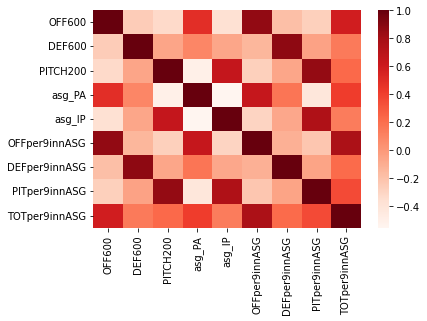

In [11]:
all_stars_only_quantitative_variables = all_stars_df[list_of_quantitative_columns]
sns.heatmap(data=all_stars_only_quantitative_variables.corr(method='pearson'), cmap='Reds')

## Scatterploat Matrix

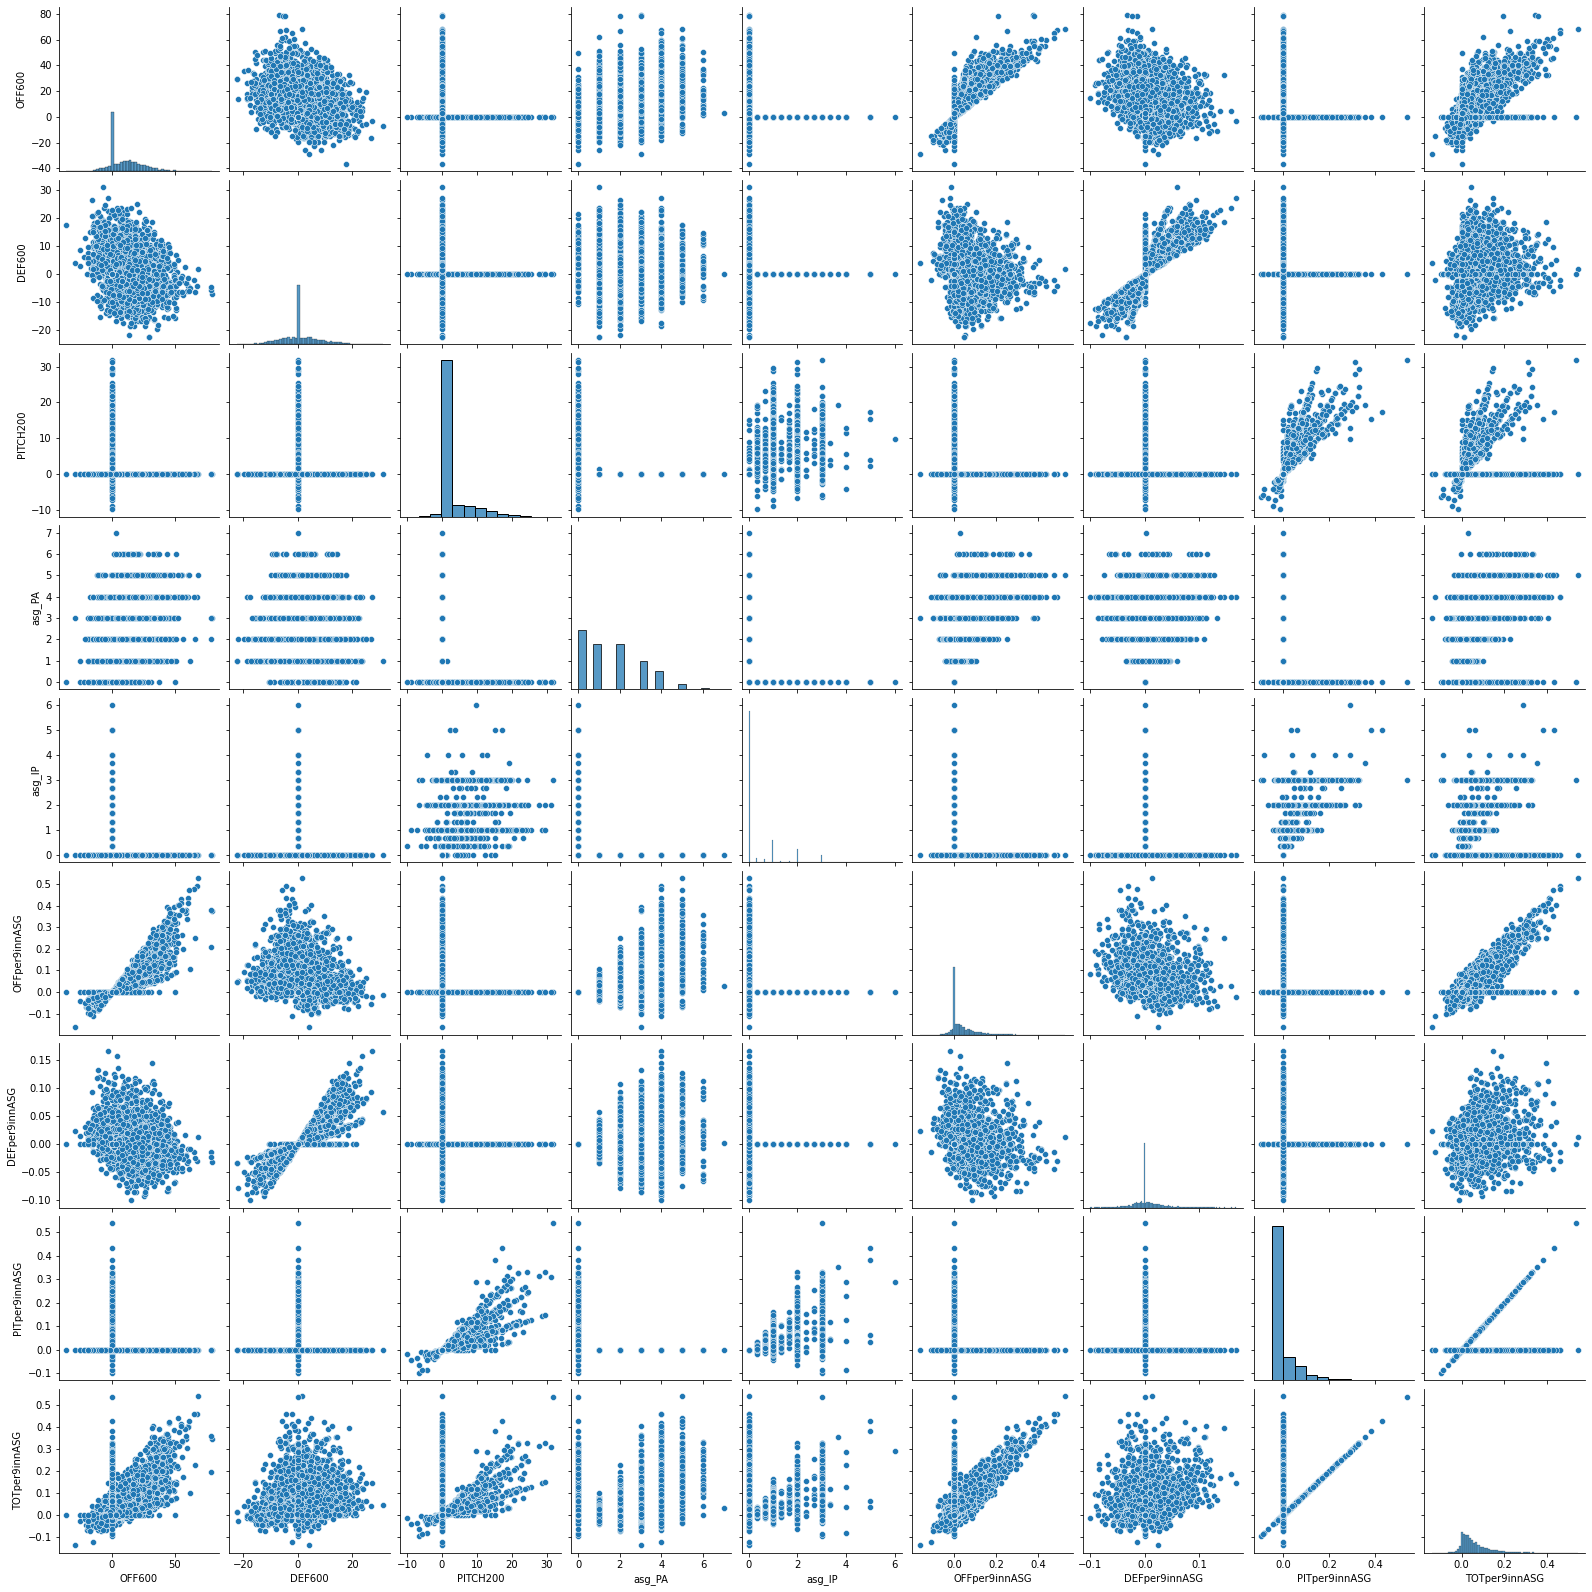

In [12]:
sns.pairplot(data=all_stars_only_quantitative_variables)

## Analisis de un subconjunto de variables 

### Subconjunto de variables cuantitativas elegidas

- asg_PA
- OFF600
- DEF600 

### Histogramas

<AxesSubplot:>

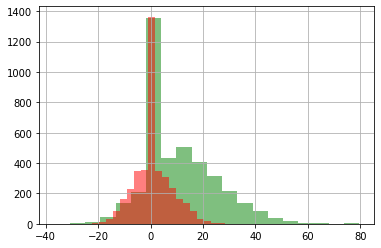

In [13]:
list_of_selected_columns = ['OFF600','DEF600','asg_PA']
all_stars_only_selected_variables = all_stars_only_quantitative_variables[list_of_selected_columns]


all_stars_only_selected_variables['OFF600'].hist(alpha = 0.5, bins =20, color = 'green')
all_stars_only_selected_variables['DEF600'].hist(alpha = 0.5, bins =20, color = 'red')


<AxesSubplot:>

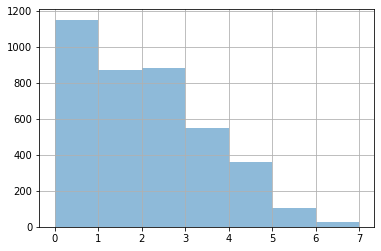

In [14]:
all_stars_only_selected_variables['asg_PA'].hist(alpha = 0.5, bins =7)

### Grafico de violín

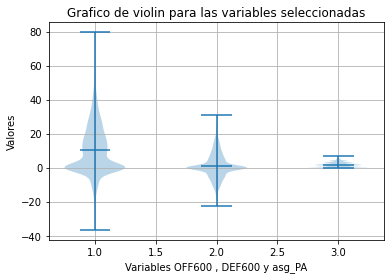

In [15]:
plt.title('Grafico de violin para las variables seleccionadas')
plt.violinplot(all_stars_only_selected_variables, showmeans = True)
plt.xlabel("Variables OFF600 , DEF600 y asg_PA")
plt.ylabel("Valores")
plt.grid(True)
plt.show()

### Boxplots

[Text(0.5, 1.0, 'Boxplot variables seleccionadas'),
 Text(0.5, 0, 'variables'),
 Text(0, 0.5, 'Valores')]

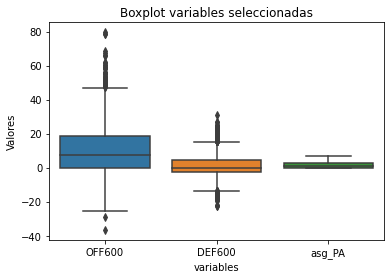

In [16]:
sns.boxplot(data = all_stars_only_selected_variables).set(title="Boxplot variables seleccionadas", xlabel = "variables", ylabel = "Valores")

### Graficos de densidad

<AxesSubplot:title={'center':'Densidad de valores'}, ylabel='Density'>

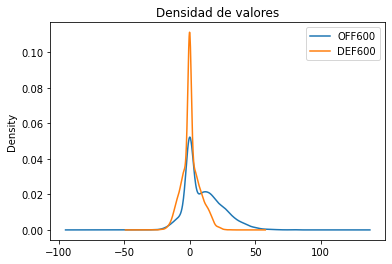

In [17]:
all_stars_only_selected_variables[['OFF600','DEF600']].plot.kde(title = "Densidad de valores")

<AxesSubplot:title={'center':'Densidad de asg_PA'}, ylabel='Density'>

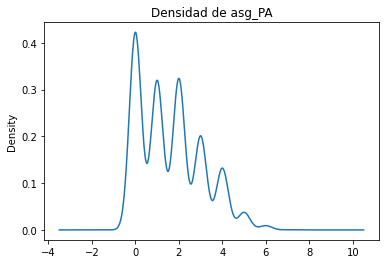

In [18]:
all_stars_only_selected_variables['asg_PA'].plot.kde(title = "Densidad de asg_PA")

### Grafico a elección

In [53]:
import plotly.express as px
fig = px.line(all_stars_only_selected_variables)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

### Concluciones

Tras analizar la información recolectada mediante los diferentes métodos de trabajo sobre el dataset anteriormente mostrados, pudimos observar y corroborar ciertos comportamientos.

En primer lugar, es importante destacar el hecho que la columna llamada ‘startingPos’ posee una gran cantidad de valores NaN (2351 de las 3930 filas son NaN representando aproximadamente un 59,8% de los valores de dicha columna).  Por lo tanto, a la hora de analizar los gráficos de barras realizados para las variables cualitativas u al realizar otro estudio donde intervenga dicha variable se deberá contemplar dicha cantidad de datos faltantes.

Por otro lado, al observar las correlaciones entre variables mediante la representación de la correlación de Pearson en un heatmap se puede destacar la estrecha relación de las variables: ‘OFF600’ con ‘OFFper9innASG’, ‘DEF600’ con ‘DEFper9innASG’ y ‘PITCH200’ con ‘PITper9innASG’. Esta correlación se ve reflejada en los casilleros correspondientes a dichas intersecciones, donde el grafico presenta una tonalidad oscura, es decir, el valor de la correlación de Pearson es más cercano a 1. Sin embargo, esta estrecha relación se basa en la propia definición de las variables explicada en la exploración inicial del dataset. Por este motivo, para el desarrollo del ítem 3 se decidió observar con mayor profundidad la relación entre las variables 'OFF600', 'DEF600' y 'asg_PA'. 

Esto debido a que las tres variables nombradas están relacionadas de tal forma que el valor de ‘asg_PA’ es utilizado al realizar el cálculo de los valores de 'OFF600' y 'DEF600'. En el heatmap se puede observar  la existencia de dicha relación. De esta forma, resulta de interés realizar las comparaciones graficas en conjunto utilizando las variables  'OFF600' y 'DEF600’ que son afectadas por ‘asg_PA’. Para esta actividad, tanto en el gráfico de barras como en el gráfico de densidad resultaron de una mayor utilidad a la hora de verificar su correlación. 


## Parte 2 (Spotify)

## Resumen del dataset Spotify

### Descripción de cada columna

| Columna  | Descripción  |
|---|---|
| genre  | Género al cual pertenece.|
| popularity  | Valor en el rango de 0-100 calculado según la cantidad de visitas de una grabación y que tan recientes son dichas visitas.|
| acousticness | Estimación de la probabilidad de que sea acústica.|
| danceability  |  Escala en el rango de 0-1 utilizada para describir cuan apto es para bailar es una grabación.|
| duration_ms  |  Duración en milisegundos.|
|  energy  | Representación de la intensidad o energía de una grabación.|
| liveness | Estimación de la probabilidad de que la grabación se realizó frente a al público.|
| loudness  | Representa el nivel de sonoridad.|
| speechiness | Valor relacionado a la cantidad de palabras dichas en la grabación, valores cercanos a 0 representan grabaciones con escasas palabras y los valores cercanos a 1 se asignan a aquellas grabaciones con únicamente palabras.|
| tempo | Estimación del BPM (Beat per minute).|
| valence | Estimación de la positividad de una grabación, valores cercanos a 1 corresponden con pistas "positivas" y los valores cercanos a 0 son asignados a aquellas pistas "negativas" o tristes.|

In [32]:
spotify = pd.read_csv('./datasets/dataset_spotify.xlsx - datset_spotify.csv')
spotify

,genre,popularity,acousticness,danceability,duration_ms,energy,liveness,loudness,speechiness,tempo,valence
0,Dance,99,"0,04","0,73",190440,"0,55","0,11","(5,29)","0,09","170,00","0,34"
1,Dance,83,"0,11","0,78",208787,"0,61","0,13","(4,59)","0,05","100,07","0,80"
2,Dance,87,"0,04","0,74",222653,"0,64","0,35","(4,55)","0,04","105,01","0,57"
3,Dance,78,"0,02","0,59",220573,"0,70","0,06","(5,33)","0,04","104,96","0,25"
4,Dance,72,"0,42","0,73",200773,"0,65","0,09","(4,39)","0,05","103,98","0,46"
...,...,...,...,...,...,...,...,...,...,...,...
995,Soul,42,"0,73","0,59",146693,"0,38","0,39","(8,91)","0,03","85,21","0,64"
996,Soul,43,"0,00","0,45",175427,"0,64","0,13","(5,67)","0,03","89,85","0,09"
997,Soul,41,"0,00","0,51",303640,"0,62","0,11","(7,07)","0,20","91,90","0,25"
998,Soul,44,"0,43","0,67",246787,"0,57","0,12","(5,68)","0,08","97,13","0,51"


In [33]:
spotify.isna().sum()

genre             0
popularity        0
 acousticness     0
 danceability     0
duration_ms       0
 energy           0
 liveness         0
 loudness         0
 speechiness      0
 tempo            0
 valence          0
dtype: int64

In [34]:
spotify.dtypes

genre             object
popularity         int64
 acousticness     object
 danceability     object
duration_ms        int64
 energy           object
 liveness         object
 loudness         object
 speechiness      object
 tempo            object
 valence          object
dtype: object

In [35]:
spotify.columns

Index(['genre', 'popularity', ' acousticness ', ' danceability ',
       'duration_ms', ' energy ', ' liveness ', ' loudness ', ' speechiness ',
       ' tempo ', ' valence '],
      dtype='object')

In [36]:
spotify_to_numeric = spotify.loc[:, [' acousticness ', ' danceability ', ' energy ', ' liveness ', ' loudness ', ' speechiness ', ' tempo ', ' valence ']]
spotify_to_numeric

,acousticness,danceability,energy,liveness,loudness,speechiness,tempo,valence
0,"0,04","0,73","0,55","0,11","(5,29)","0,09","170,00","0,34"
1,"0,11","0,78","0,61","0,13","(4,59)","0,05","100,07","0,80"
2,"0,04","0,74","0,64","0,35","(4,55)","0,04","105,01","0,57"
3,"0,02","0,59","0,70","0,06","(5,33)","0,04","104,96","0,25"
4,"0,42","0,73","0,65","0,09","(4,39)","0,05","103,98","0,46"
...,...,...,...,...,...,...,...,...
995,"0,73","0,59","0,38","0,39","(8,91)","0,03","85,21","0,64"
996,"0,00","0,45","0,64","0,13","(5,67)","0,03","89,85","0,09"
997,"0,00","0,51","0,62","0,11","(7,07)","0,20","91,90","0,25"
998,"0,43","0,67","0,57","0,12","(5,68)","0,08","97,13","0,51"


In [37]:
spotify_to_numeric_columns = list(spotify_to_numeric.columns)
for column in spotify_to_numeric_columns:
    spotify_to_numeric[column] = spotify_to_numeric[column].str.replace("[( )]", "", regex=True)
    spotify_to_numeric[column] = spotify_to_numeric[column].str.replace(",", ".")
    spotify_to_numeric[column] = pd.to_numeric(spotify_to_numeric[column])
    spotify[column] = spotify_to_numeric[column]

spotify

,genre,popularity,acousticness,danceability,duration_ms,energy,liveness,loudness,speechiness,tempo,valence
0,Dance,99,0.04,0.73,190440,0.55,0.11,5.29,0.09,170.00,0.34
1,Dance,83,0.11,0.78,208787,0.61,0.13,4.59,0.05,100.07,0.80
2,Dance,87,0.04,0.74,222653,0.64,0.35,4.55,0.04,105.01,0.57
3,Dance,78,0.02,0.59,220573,0.70,0.06,5.33,0.04,104.96,0.25
4,Dance,72,0.42,0.73,200773,0.65,0.09,4.39,0.05,103.98,0.46
...,...,...,...,...,...,...,...,...,...,...,...
995,Soul,42,0.73,0.59,146693,0.38,0.39,8.91,0.03,85.21,0.64
996,Soul,43,0.00,0.45,175427,0.64,0.13,5.67,0.03,89.85,0.09
997,Soul,41,0.00,0.51,303640,0.62,0.11,7.07,0.20,91.90,0.25
998,Soul,44,0.43,0.67,246787,0.57,0.12,5.68,0.08,97.13,0.51


In [38]:
spotify.dtypes

genre              object
popularity          int64
 acousticness     float64
 danceability     float64
duration_ms         int64
 energy           float64
 liveness         float64
 loudness         float64
 speechiness      float64
 tempo            float64
 valence          float64
dtype: object

In [39]:
list_of_quantitative_columns = ['popularity', ' acousticness ', ' danceability ', 'duration_ms', ' energy ', ' liveness ', ' loudness ', ' speechiness ', ' tempo ', ' valence ']
summarization_operations = ['mean', 'median', 'mode','min','max']


summarized_df = create_dataframe_with_each_summarization(
    dataframe=spotify,
    columns=list_of_quantitative_columns,
    summarization_ops=summarization_operations)

quantiles_df = create_dataframe_with_quantiles(
    dataframe=spotify, 
    columns=list_of_quantitative_columns, 
    quantiles=[0.25, 0.75])

pd.merge(left=summarized_df, right=quantiles_df, left_on='Nombre de columna', right_on='Nombre de columna')

,Nombre de columna,mean,median,mode,min,max,Quantile 25.0%,Quantile 75.0%
0,popularity,44.55700,45.000,"{0: 47.0, 1: nan}",2.00,99.00,33.0000,57.0000
1,acousticness,0.36515,0.220,"{0: 0.0, 1: nan}",0.00,1.00,0.0500,0.7000
2,danceability,0.57285,0.600,"{0: 0.68, 1: nan}",0.08,0.95,0.4400,0.7200
3,duration_ms,248375.52200,224600.000,"{0: 265960, 1: 268800}",33160.00,1747733.00,192609.7500,276419.5000
4,energy,0.55859,0.600,"{0: 0.61, 1: 0.63}",0.00,1.00,0.3900,0.7500
5,liveness,0.19993,0.120,"{0: 0.11, 1: nan}",0.01,0.99,0.1000,0.2400
6,loudness,9.60466,7.765,"{0: 7.52, 1: nan}",0.76,37.73,5.5475,11.1775
7,speechiness,0.09087,0.050,"{0: 0.04, 1: nan}",0.02,0.68,0.0400,0.0925
8,tempo,116.71981,115.025,"{0: 120.0, 1: nan}",52.65,209.77,92.8875,136.9450
9,valence,0.45860,0.450,"{0: 0.04, 1: nan}",0.03,0.98,0.2400,0.6800


In [40]:
spotify_quantitative = spotify.iloc[:, 1:11]
spotify_quantitative

,popularity,acousticness,danceability,duration_ms,energy,liveness,loudness,speechiness,tempo,valence
0,99,0.04,0.73,190440,0.55,0.11,5.29,0.09,170.00,0.34
1,83,0.11,0.78,208787,0.61,0.13,4.59,0.05,100.07,0.80
2,87,0.04,0.74,222653,0.64,0.35,4.55,0.04,105.01,0.57
3,78,0.02,0.59,220573,0.70,0.06,5.33,0.04,104.96,0.25
4,72,0.42,0.73,200773,0.65,0.09,4.39,0.05,103.98,0.46
...,...,...,...,...,...,...,...,...,...,...
995,42,0.73,0.59,146693,0.38,0.39,8.91,0.03,85.21,0.64
996,43,0.00,0.45,175427,0.64,0.13,5.67,0.03,89.85,0.09
997,41,0.00,0.51,303640,0.62,0.11,7.07,0.20,91.90,0.25
998,44,0.43,0.67,246787,0.57,0.12,5.68,0.08,97.13,0.51


<AxesSubplot:title={'center':'Correlación de Pearson'}>

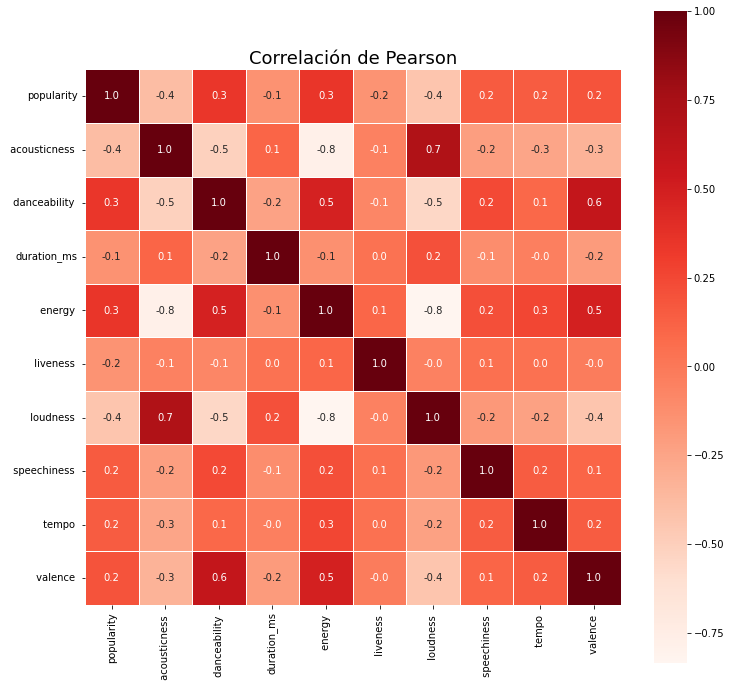

In [41]:
plt.figure(figsize=(12,12))
plt.title('Correlación de Pearson', size = 18)
sns.heatmap(spotify_quantitative.corr(method='pearson'), annot=True, fmt=".1f", linewidths=.5, square = True, cmap = 'Reds')

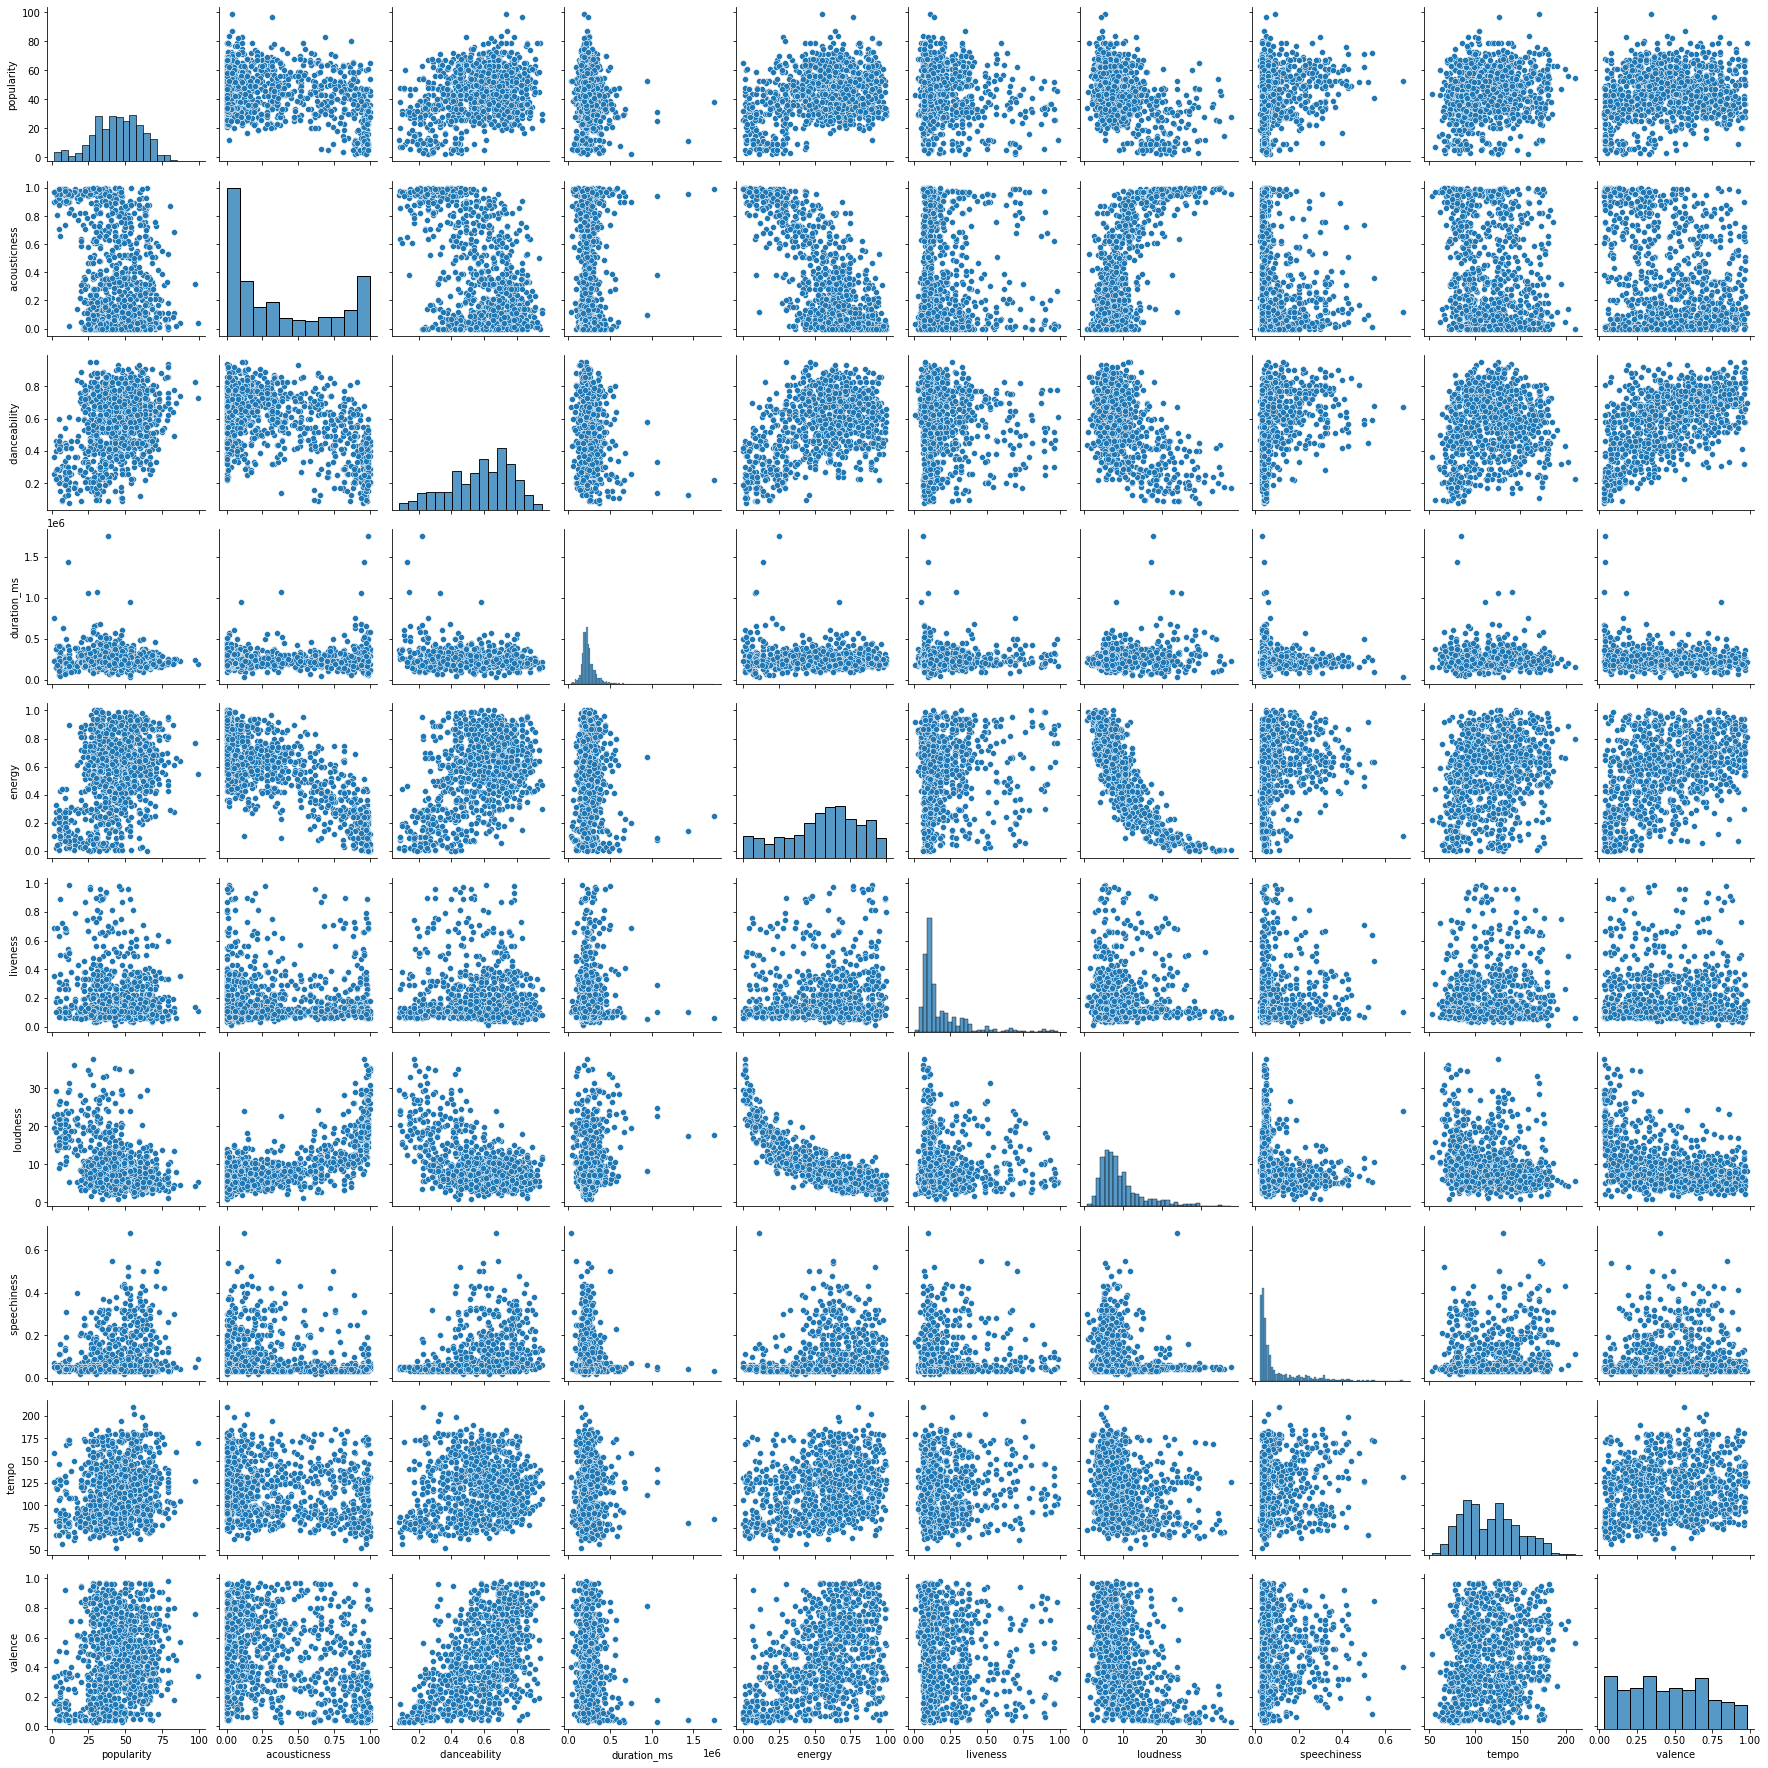

In [42]:
sns.pairplot(spotify_quantitative)

### Promedio de popularidad según género

In [43]:
spotify.genre.value_counts()

Pop           82
Electronic    81
Jazz          81
Folk          80
Hip-Hop       80
Rock          80
World         79
Reggaeton     78
Reggae        76
Dance         75
Opera         72
Classical     72
Soul          64
Name: genre, dtype: int64

In [44]:
popularity_mean = spotify.groupby(['genre'])['popularity'].mean().reset_index()
popularity_mean

,genre,popularity
0,Classical,31.250000
1,Dance,58.186667
2,Electronic,39.333333
3,Folk,49.750000
4,Hip-Hop,57.687500
5,Jazz,42.197531
6,Opera,12.791667
7,Pop,67.365854
8,Reggae,36.171053
9,Reggaeton,36.871795


In [45]:
sns.set(rc={'figure.figsize':(14,10)})

Text(0, 0.5, 'Popularidad media')

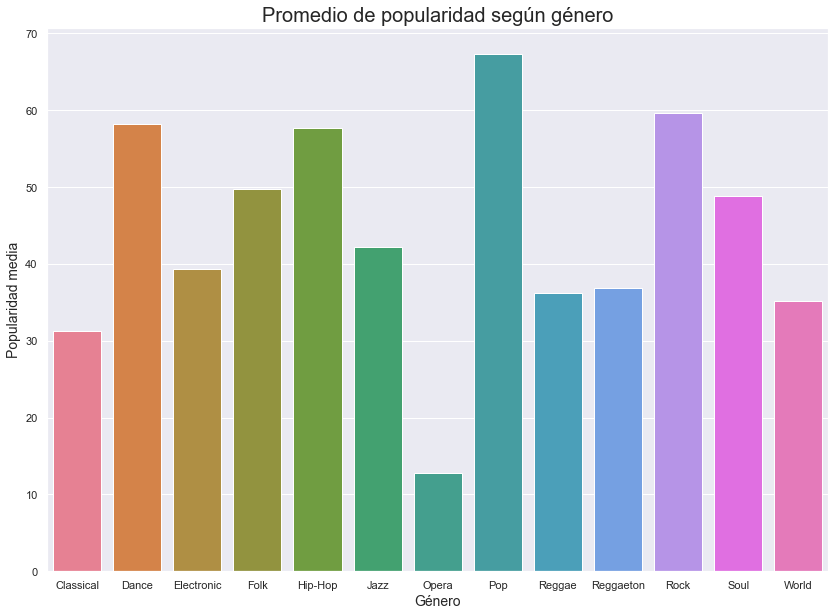

In [46]:
g = sns.barplot(x=popularity_mean.genre, y=popularity_mean.popularity, palette='husl')
g.set_title("Promedio de popularidad según género", fontsize=20)
g.set_xlabel("Género", fontsize=14)
g.set_ylabel("Popularidad media", fontsize=14)

In [47]:
spotify.groupby(['genre'])['popularity'].median()

genre
Classical     32.0
Dance         57.0
Electronic    39.0
Folk          49.0
Hip-Hop       55.5
Jazz          41.0
Opera         11.0
Pop           66.0
Reggae        34.0
Reggaeton     34.5
Rock          59.0
Soul          48.0
World         33.0
Name: popularity, dtype: float64

### Relacion entre la popularidad y la duracion de las canciones

In [ ]:
spotify.plot.scatter(x = 'duration_ms', y = 'popularity',  color='black', title = "Popularidad de una cancion segun su duracion", xlabel = "Duracion en milisegundos" , ylabel = "Popularidad")

spotify_min = spotify.assign(duration_ms = lambda x: (spotify["duration_ms"] / 60000))
spotify_min.rename(columns={"duration_ms": "duration_min"}, inplace = True)

spotify_min.plot.scatter(x = 'duration_min', y = 'popularity',  color='green', title = "Popularidad de una cancion segun su duracion", xlabel = "Duracion en minutos" , ylabel = "Popularidad")

In [ ]:
(spotify_min["duration_min"] > 7).value_counts()

### Conclusión 


Como primera pregunta de investigación sobre el dataset, se optó por analizar cual de los géneros musicales era el más popular. Para ello, utilizamos un gráfico de barra para poder comparar visualmente la popularidad de cada género. Se llego a la conclusión de que el pop es el género con más popularidad, como se observa en el gráfico.

Como segunda pregunta de investigación para trabajar sobre el dataset, se optó por analizar la relación entre la duración de las grabaciones (almacenada en milisegundos en la columna de llamada “duration_ms”) y la popularidad de las grabaciones. En el proceso de exploración de los datos, al realizar la representación de la correlación de Pearson mediante un heatmap se puede observar que dichas variables poseen una leve correlación negativa.

Con el fin de realizar un análisis más profundo de dicha relación, se utilizaron dos gráficos de dispersión. El primero de ellos representa la relación entre la duración en milisegundos de las grabación con su popularidad, mientras que el segundo realiza dicha representación mediante los minutos de cada grabación ya que resulta más natural esta escala. De esta forma, observamos gráficamente que el mayor número de grabaciones se encuentran dentro del umbral de 0 a 400.000 milisegundos (0-6,7 minutos aproximadamente), por lo que es lógico pensar que tanto las grabaciones más populares como aquellas que no lo son pertenecen a dicho conjunto. Sim embargo, a partir de dicho umbral podemos observar una tendencia a la caída de la popularidad en relación con el aumento de la duración.

Esta tendencia del decrecimiento de la popularidad de una grabación respecto al aumento de su duración destacable, sin embrago a fin de obtener resultados más argumentados se debería conseguir una mayor cantidad de datos debido al hecho de que se posee una “pequeña” cantidad de grabaciones que superan los 7 minutos en relación con el total (48 grabaciones de un total de 1000, representando un 4,8%).
